# Loading in our data from main.ipynb to build the initial model

### Loading the data

In [30]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

with open("prepared_data.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
X_val = data["X_val"]
X_test = data["X_test"]
y_train = data["y_train"]
y_val = data["y_val"]
y_test = data["y_test"]
class_weights_dict = data["class_weights"]
num_classes = data["num_classes"]

### Initial Data Augmentation

In [31]:
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")

Class weights: {0: np.float64(0.37916666666666665), 1: np.float64(0.37916666666666665), 2: np.float64(0.37916666666666665), 3: np.float64(0.37916666666666665), 4: np.float64(0.37916666666666665), 5: np.float64(0.37916666666666665), 6: np.float64(0.37916666666666665), 7: np.float64(3.7916666666666665), 8: np.float64(3.7916666666666665), 9: np.float64(3.7916666666666665), 10: np.float64(3.7916666666666665), 11: np.float64(3.7916666666666665), 12: np.float64(3.7916666666666665), 13: np.float64(3.7916666666666665), 14: np.float64(3.7916666666666665), 15: np.float64(3.7916666666666665), 16: np.float64(3.7916666666666665), 17: np.float64(3.7916666666666665), 18: np.float64(3.7916666666666665), 19: np.float64(3.7916666666666665), 20: np.float64(3.7916666666666665), 21: np.float64(3.7916666666666665), 22: np.float64(3.7916666666666665), 23: np.float64(0.7583333333333333)}


### Building the model

In [32]:
def leNet_model(num_classes):
    model = Sequential()

    model.add(Conv2D(60, (5, 5), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = leNet_model(num_classes)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 60)     │         4,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1080)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 500)            │       540,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │        12,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,314 (2.19 MB)

 Trainable params: 573,314 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [33]:
history = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=50,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    shuffle=True,
    verbose=1
)

Epoch 1/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1059 - loss: 3.0142 - val_accuracy: 0.2508 - val_loss: 2.4820
Epoch 2/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2378 - loss: 2.5033 - val_accuracy: 0.2409 - val_loss: 2.4365
Epoch 3/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2722 - loss: 2.2859 - val_accuracy: 0.2936 - val_loss: 2.2302
Epoch 4/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2927 - loss: 2.1567 - val_accuracy: 0.3007 - val_loss: 2.1624
Epoch 5/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3096 - loss: 2.0430 - val_accuracy: 0.3382 - val_loss: 2.0513
Epoch 6/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3251 - loss: 1.9381 - val_accuracy: 0.3571 - val_loss: 1.9921
Epoch 7/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3497 - loss: 1.7911 - val_accuracy: 0.3121 - val_loss: 2.0956
Epoch 8/15
819/819 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3527 - loss: 1.7416 - val_accuracy: 0.

### Evaluating the model

285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4098 - loss: 1.7361
Test Loss: 1.81735360622406
Test Accuracy: 0.4209890067577362


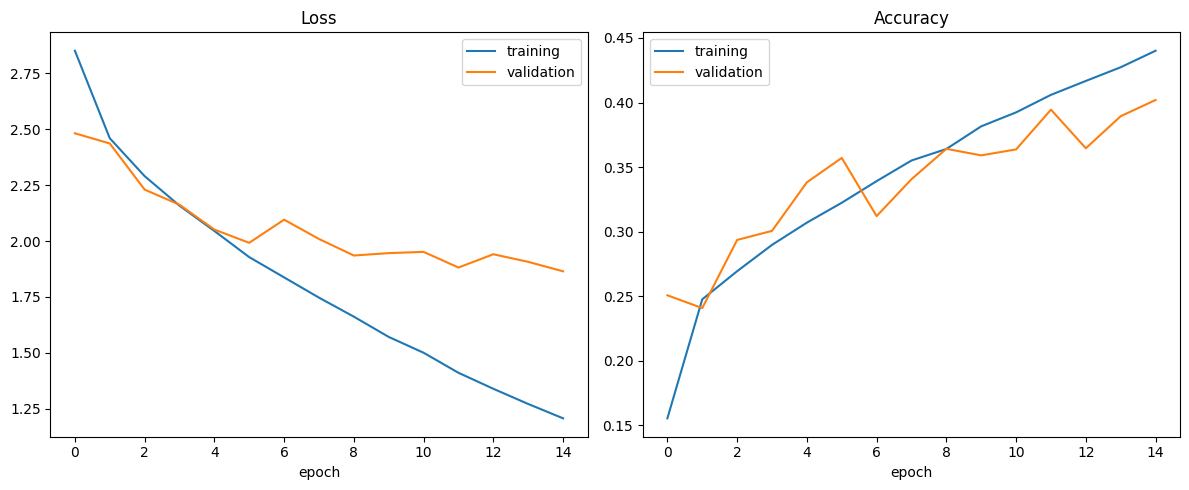

In [36]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title("Loss")
plt.xlabel("epoch")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title("Accuracy")
plt.xlabel("epoch")

plt.tight_layout()
plt.show()
